In [18]:
import os
os.chdir("/home/seojin/HR/student_data_analysis")
import prj_info

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F

import sys
sys.path.append(prj_info.module_path)

import sj_higher_function
from sj_higher_function import recursive_map, flatten, relation_map, relation_df
import sj_preprocessing as preproc
from sj_preprocessing import get_column_keywords, reverse_dict, search_multi_conditions, is_nan, is_not_nan, to_series, get_columns_keywords, search, group, compare_df, search_column_index, change_df, replace_str, one_hot_encoding, one_hot_encodings, remove_non_need_column
import sj_sequence as ss
import sj_file_system
from sj_file_system import str_join
import sj_ml
import F_Visualize

In [33]:
data_raw_including_path_index_info = {
    "1 grade" : 0,
    "2 grade" : 1,
    "3 grade" : 2,
    "4 grade" : 3,
    "5 grade" : 4,
    "6 grade" : 5,
    "7 grade" : 6,
    "8 grade" : 7,
    "9 grade" : 8,
}

def load_layer_info(prefix):
    return sj_file_system.load(os.path.join(prj_info.prj_home_path, "layer_info", str_join([prefix, "layer_info"])))

def prefix(target_block, target_middle_chapter, target_layer = None):
    data_type = ""
    if input_path is not None:
        data_type = specific_prefix
    elif is_use_sas:
        data_type = "sas"
    
    remove_s = ""
    if is_remove_S:
        remove_s = "removeS"
    
    join_strs = []
    if data_type != "":
        join_strs.append(data_type)
    
    join_strs.append(target_block)
    join_strs.append(str(target_middle_chapter))
    
    if target_layer != None:
        join_strs.append(target_layer)
    
    if remove_s != "":
        join_strs.append(remove_s)

    return str_join(join_strs)

def get_higher_layer_info(layer_info, block, middle_chapter):
    higher_layer_info = {}
    higher_layer_info[block] = {}
    higher_layer_info[block][middle_chapter] = get_layers(layer_info[block][middle_chapter])[0]

    return higher_layer_info

def get_layers(layer_values):
    initial_value = -1

    # 첫번째 인덱스는 0부터 시작하므로...
    result = ss.construct_layer_list([max_layer_info(layer_values)[0] + 1, max_layer_info(layer_values)[1]], 
                            initial_value)

    first_info_index = 0
    for layer in layer_values:
        layer_values = layer.split("_")

        layer_entry_info = [int(re.search('\d', layer_value).group()) for layer_value in layer_values]
        layer_entry_info[1] = layer_entry_info[1] - 1 # 두번째 정보는 1부터 시작하므로..

        ss.set_entry(target_list=result, 
                  entry_indexes=layer_entry_info, 
                  value = layer)

    sj_higher_function.recursive_proc(result, lambda x: remove_init_value(x, initial_value))
    return result

def load_student_info(layer_info, data_index_info):
    st_input_info = {}
    for block in layer_info.keys():
        st_input_info[block] = {}
        for middle_chapter in layer_info[block]:
            student_input_datas = []
            for target_grade in data_index_info.keys():
                # load student input data
                student_input_data = pd.read_excel(os.path.join(preprocessed_dir_path, str_join([data_prefix(), "판본", block, "중단원", str(middle_chapter), target_grade, "student_input.xlsx"])), 
                                                   header=[0,1,2,3,4])
                header = pd.MultiIndex.from_tuples(recursive_map(list(student_input_data.columns.to_numpy()), lambda x: "" if type(x) == str and "Unnamed" in x else x))
                student_input_data.columns = header
                student_input_data = student_input_data.iloc[1:]

                # add student code header
                headers = []
                for i in range(0, len(student_input_data.columns)):
                    if i == 0:
                        headers.append(("student_code", "", "", "", ""))
                    else:
                        headers.append(student_input_data.columns[i])

                student_input_data.columns = pd.MultiIndex.from_tuples(headers)
                
                target_train_layers = get_higher_layer_info(layer_info, target_block, target_middle_chapter)[target_block][target_middle_chapter]

                for t_l in target_train_layers:                    
                    # self 자기자신
                    student_input_data = change_df(student_input_data,
                                                       column_name = [t_l, "studied " + t_l, "", "", ""], 
                                                       apply_func = lambda element: 1 if element == 0 else element)
                
                # Apped
                student_input_datas.append(student_input_data)

            st_input_info[block][middle_chapter] = student_input_datas
    return st_input_info

def draw_accuracy(model, acc_type="ep_train_acc", figsize = (5,5)):
    plt.clf()
    # acc_type: ep_train_acc, batch_train_acc, ep_test_acc, batch_test_acc
    legends = ""
    dict_accs = {}
    if "train" in acc_type:
        dict_accs = model.train_acc
    else:
        dict_accs = model.test_acc
    accs = [float(e) for e in dict_accs[acc_type]]
    
    plt.figure(figsize=figsize)
    plt.plot(np.arange(0, len(accs)), accs)
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend([acc_type])
    
    split_prefix = model.prefix.split("_")
    for i in range(0, len(split_prefix)):
        if split_prefix[i].startswith("L"):
            level_i = i
    title = str_join([model.name, str_join(split_prefix[level_i:level_i+2])])
    plt.title(title)
    # plt.savefig(os.path.join(prj_info.prj_home_path, title + "_" + acc_type), dpi=300, bbox_inches='tight')
    plt.show()

def max_layer_info(layer_levels):
    max_layer_info = np.repeat(0, find_max_depth(layer_levels))
    
    list_layers = split_layers(layer_levels)
    for layer in list_layers:
        for i in range(0, len(max_layer_info)):
            max_layer_info[i] = max(max_layer_info[i], layer[i])
    return max_layer_info

def find_max_depth(layer_levels):
    max_depth = 0
    for layer in layer_levels:
        max_depth = max(max_depth, len(layer.split("_")))
    return max_depth

def split_layers(layer_levels):
    list_layers = []
    for layer in list(layer_levels):
        list_layers.append([int(re.search('\d', layer_value).group()) for layer_value in layer.split("_")])
    return list_layers

def remove_init_value(vector, initial_value):
    count = Counter(vector) 
    for _ in range(0, count[initial_value]):
        vector.remove(initial_value)
        
def data_prefix():
    data_prefix = ""
    data_prefix = specific_prefix
        
    return data_prefix

def fill_na(student_data):
    columns = summary_columns(student_data.columns)
    target_column_indexes = []
    for i in range(0, len(columns)):
        if "개념원리정답율" in columns[i] or "개념적용정답율" in columns[i] or "개념활용정답율" in columns[i]:
            target_column_indexes.append(i)
        
    for c_index in target_column_indexes:
        student_data.iloc[:, c_index] = student_data.iloc[:, c_index].fillna(-1)

    return student_data

def summary_columns(column_names):
    new_column_names = []
    for column_name in column_names:

        # 축약
        new_column_name = list(column_name)
        for i in range(0, len(column_name)):
            name = column_name[i]
            if name == "Cognitive Domain" or name == "Direction(범위)":
                new_column_name[i] = ""
            elif "(S1+S2+S3+K1)" in name:
                new_column_name[i] = "부분 "+  name.split(" ")[1] + " c[L1]"
            elif "(S1+S2+S3+K1+L1)" in name:
                new_column_name[i] = "총 "+  name.split(" ")[1]

        # (~)검출
        for i in range(0, len(column_name)):
            name = column_name[i]
            summary_test = re.search("\([A-Z]{1}\d?\)", name)
            if summary_test == None:
                continue
            else:
                summary_txt = summary_test.group()
                new_column_name[i] = summary_txt

        # 마지막 간추리기
        new_column_name = str_join(new_column_name, " / ")

        # 추가
        new_column_names.append(new_column_name)
    return new_column_names

class DNN(nn.Module):
    def __init__(self, 
                 input_shape, 
                 output_shape,
                 learning_rate=0.001,
                 is_gpu=False,
                 ):
        super(DNN, self).__init__()
        
        # Layers
        self.input_shape = input_shape
        self.output_shape = output_shape
        
        self.fc1 = nn.Linear(input_shape, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, output_shape)
        
        # hyperparameters
        self.learning_rate = learning_rate
        self.is_gpu = is_gpu
        
        # optimization
        self.criterion = nn.CrossEntropyLoss()

        self.optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        
        # GPU
        if self.is_gpu and torch.cuda.is_available():
            self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
            self.to(self.device)
        else:
            self.device = torch.device("cpu")

    def forward(self, x):
        x = x.float()
        x = F.relu(self.fc1(x.view(-1, self.input_shape)))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.log_softmax(self.fc6(x), dim=1)
        return x
    
    def partial_fit(self, X_train, y_train):
        self.train()
        
        data_count = len(y_train)

        X = X_train
        Y = y_train
            
        self.optimizer.zero_grad()
        #loss = F.cross_entropy(self(X), Y)
        #loss.backward()
        self.criterion(self(X), Y).backward()
        
        self.optimizer.step()
    
    def predict(self, X):
        return torch.argmax(self.forward(X), axis=1)
        
    def df_to_tensor(self, df):
        return torch.tensor(df.values).float()
        
    def is_use_gpu(self):
        return self.is_gpu
    
    def is_use_tensor(self):
        return True
    
    def get_device(self):
        return self.device
        
    def is_partial_fit(self):
        return True

class SGD_C:
    def __init__(self, classes):
        self.model = SGDClassifier(loss="hinge", shuffle=True)
        self.classes = classes
        
    def partial_fit(self, X_train, y_train):
        self.model.partial_fit(X_train, y_train, self.classes)
    
    def predict(self, X):
        return self.model.predict(X)
    
    def is_partial_fit(self):
        return True
    
    def is_use_tensor(self):
        return False
    
class SVM:
    def __init__(self, kernel, C = None):
        if C != None:
            self.model = SVC(kernel=kernel, C=C)
        else:
            self.model = SVC(kernel=kernel, C=C)
            
    def fit(self, X_train, y_train):
        self.model.fit(X_train, y_train)
    
    def predict(self, X):
        return self.model.predict(X)
    
    def is_partial_fit(self):
        return False
    
    def is_use_gpu(self):
        return False
    
    def is_use_tensor(self):
        return False
    
def save_DNN(a):
    print(a)

def save_SGD(a):
    print(a)
    
def sort_knowledge_level(layer_list):
    k_ls = []
    for layer in layer_list:
        layer = layer.split("_")

        first_k_l_axis = int(layer[0].split("L")[1])
        second_k_l_axis = int(layer[1])

        k_ls.append((first_k_l_axis, second_k_l_axis))

    return list(map(lambda x: "L" + str(x[0]) + "_" + str(x[1]), sorted(k_ls)))

def get_sub_study_path(model, target_sub_columns_names, alias_sub_column_name):
    # layers_level
    layers_level = sorted(layer_info[target_block][target_middle_chapter].items(), reverse=True)
    
    # target_layers_level
    target_layers_level = []
    for layer_level in layers_level:
        layer_level = layer_level[0]
        
        # higher layer는 SVM coef가 없으므로 제외
        if layer_level not in higher_layer_info[target_block][target_middle_chapter]:
            target_layers_level.append(layer_level)
    
    # select mastery
    target_mastery_index = label_category["Mastery"]
    
    # select column
    columns = summary_columns(model.X_train.columns)
    target_column_indexes = []

    for level in target_layers_level:
        for i in range(0, len(columns)):
            if level in columns[i] and sum([col in columns[i] for col in target_sub_columns_names]) >= 1:
                target_column_indexes.append(i)
    target_columns = np.array(columns)[target_column_indexes]
    
    # coef
    target_coef = model.model.model.coef_[target_mastery_index]
    target_coef = target_coef[target_column_indexes]
    
    # Extract coefficient
    coef_dic = {}
    for level in target_layers_level:
        coef_dic[level] = {}
        for coef in zip(target_columns, target_coef):
            coef_name = coef[0]
            coef_value = coef[1]
            if level in coef_name:
                coef_dic[level][coef_name.split(" / ")[1]] = coef_value
    
    # result
    result = {}
    for level in coef_dic.keys():
        coef_array = np.array([coef_dic[level][name] for name in target_sub_columns_names])
        
        max_coeff_i = np.argmax(coef_array)

        result[level] = alias_sub_column_name[max_coeff_i:len(target_sub_columns_names)]
    
    for level in coef_dic.keys():
        print(level, "/", str_join(result[level], deliminator=" -> "), ";")
        
    return coef_dic,result

def studied_pattern(data, model_type, target_v, mastery):
    predicts = dep_model(model_type=model_type, target_v=target_v, data=data)
    mastery_data = data[predicts == label_category[mastery]]
    studied_data = get_column_keywords(mastery_data, [target_v, "studied", "", "", ""], search_mode=0)
    studied_columns = studied_data.columns
    
    sort_c_is = []
    for t_c in sorted_knowledge:
        for c_i in range(0, len(studied_columns)):
            column = studied_columns[c_i]

            if t_c in column[1]:
                sort_c_is.append(c_i)
                break
    
    studied_data = studied_data.iloc[:, sort_c_is]
    
    if len(studied_data) == 0:
        return None
    
    pattern = Counter(studied_data.astype(int).astype(str).apply(lambda strs: str_join(strs, ""), axis=1))
    from operator import itemgetter
    
    return sorted(pattern.items(), key=itemgetter(1), reverse=True)

def get_grade_testData(test_data):
    test_data_length = {}
    for grade_i in range(0, len(st_input_info[target_block][target_middle_chapter])):
        test_data_length[grade_i+1] = int(len(st_input_info[target_block][target_middle_chapter][grade_i]) * test_size_ratio)
    
    grade_d = []
    for grade in test_data_length:
        start_i = sum([test_data_length[sub_g] for sub_g in range(grade - 1, 0, -1)])
        grade_d.append(test_data[start_i:start_i + test_data_length[grade]])
    return grade_d

def get_optim(grade_test, model_type, target_v, command):
    optim_index = 0
    second_index = 1
    
    select_index = 0
    if command == "optim":
        select_index = optim_index
    elif command == "second":
        select_index = second_index
    
    pattern_index = 0
    
    recommend_patterns = []
    for grade_i in range(0, len(grade_test)):
        grade = grade_i + 1
        
        if grade in [1,2,3]:
            pattern = studied_pattern(grade_test[grade_i], model_type, target_v, "Mastery")
            try:
                rt_pt = pattern[select_index][pattern_index]
            except: # 패턴이 없는 경우
                if len(recommend_patterns) == 0:
                    rt_pt = np.nan
                else:
                    rt_pt = recommend_patterns[-1]
        elif grade in [4,5,6,7,8,9]:
            
            stp1 = studied_pattern(grade_test[grade_i], model_type, target_v, "Mastery")
            stp2 = studied_pattern(grade_test[grade_i], model_type, target_v, "Partial Mastery")

            if stp1 != None:
                stp1_c = stp1.copy()

            if stp2 != None:
                stp2_c = stp2.copy()

            if stp1 is None and stp2 is None:
                result = None
            elif stp1 is None:
                result = stp2    
            elif stp2 is None:
                result = stp1
            else: # 패턴 병합
                result = []
                for p1 in stp1:
                    for p2 in stp2:
                        if p1[0] == p2[0]:
                            result += [(p1[0], p1[1] + p2[1])]
                            stp1_c.remove(p1)
                            stp2_c.remove(p2)

                result += stp1_c
                result += stp2_c
            
            patterin_index = 0
            count_index = 1    
            try:
                rt_pt = result[select_index][patterin_index]
            except:
                try:
                    if select_index == 0:
                        rt_pt = recommend_patterns[-1]
                    else:
                        rt_pt = np.nan
                except:
                    rt_pt = np.nan
                
        recommend_patterns.append(rt_pt)
        
    return recommend_patterns

def get_recommand(grade_test, model_type, target_v):
    optims = get_optim(grade_test, model_type, target_v, "optim")
    
    result = [] 
    for grade_i in range(len(data_index_info)):
        if grade_i == 0:
            result += [np.nan]
        else:
            result += [optims[grade_i - 1]]
    return result

def grade_path(test_data, model_type, target_v):
    optim_index = 0
    second_index = 1

    pattern_index = 0
    
    grade_test = get_grade_testData(test_data)
    
    optims = get_optim(grade_test, model_type, target_v, "optim")
    seconds = get_optim(grade_test, model_type, target_v, "second")
    recommends = get_recommand(grade_test, model_type, target_v)
    
    result = pd.DataFrame(columns=["optim", "second", "recommend"])
    result.loc[:, "optim"] = optims
    result.loc[:, "second"] = seconds
    result.loc[:, "recommend"] = recommends
    
    # 순서 맞추기
    
    result = change_df(result,
          column_name = "recommend", 
          apply_func = lambda element: np.nan if element == -1 else element)
    
    columns = get_column_keywords(test_data, [target_v, "studied", "", "", ""], search_mode=0).columns
    
    sort_c_is = []
    for t_c in sorted_knowledge:
        for c_i in range(0, len(columns)):
            column = columns[c_i]

            if t_c in column[1]:
                sort_c_is.append(c_i)
                break
    
    columns = [str_join(columns[c_i], " / ") for c_i in sort_c_is]

    result.index = list(data_index_info.keys())
    return result, columns

def dep_model(model_type, target_v, data):
    for i in range(0, len(target_train_layers)):
        if target_v == target_train_layers[i]:
            break
    target_i = i
    
    if model_type == "DNN":
        model = DNN_models[target_i]
        model.model.eval()
        model.model.criterion.eval()
    elif model_type == "SGD":
        model = SGD_models[target_i]
                
    target_columns = columns[target_i]
    
    data = data[target_columns]

    data = data.astype("float")
    
    if model_type == "DNN":
        return model.predict(sj_ml.df_to_tensor(data)).numpy()
    else:
        return model.predict(data)

In [35]:
label_category = {
    "Non Mastery" : 0,
    "Partial Mastery" : 1, 
    "Mastery" : 2
}
label_category_reverse = reverse_dict(label_category)

In [56]:
input_path = "/home/seojin/HR/student_data_analysis/raw_data/RJ_중1_2104B100.xlsx"

# JS_중2_22043100.xlsx a
# RJ_초5_15049100.xlsx a
# BS_초5_1504A100.xlsx a
# SG_중2_22042300.xlsx a
# RJ_중2_2204A100.xlsx a(in)
# RJ_초6_1604B100.xlsx a(in)
# RJ_중1_2104B100.xlsx a(in)
# JS_초2_12047100.xlsx a(in)
# BS_초4_14048100.xlsx a(in)

test_size_ratio = 0.2

target_block = input_path.split("/")[-1].split("_")[0]

try:
    target_middle_chapter = int(input_path.split("/")[-1].split("_")[-1].split(".")[0])
except:
    target_middle_chapter = str(input_path.split("/")[-1].split("_")[-1].split(".")[0])
    
specific_prefix = target_block

is_remove_S = True

preprocessed_dir_path = os.path.join(prj_info.prj_home_path, "preprocessed")
model_dir_path = "/mnt/sdb2/seojin/st_p" # Model 저장소

In [57]:
# Load Preconfig
layer_info = load_layer_info(prefix(target_block, target_middle_chapter))

data_index_info = data_raw_including_path_index_info

higher_layer_info = get_higher_layer_info(layer_info, target_block, target_middle_chapter)
target_train_layers = higher_layer_info[target_block][target_middle_chapter]

In [64]:
# Load data

st_input_info = load_student_info(layer_info, data_index_info)

st_inputs = None
for grade_i in range(0, 9):
    st_input = fill_na(st_input_info[target_block][target_middle_chapter][grade_i])
    if st_inputs is None:
        st_inputs = st_input
    else:
        st_inputs = pd.concat([st_inputs, st_input])
        

In [58]:
dnn_path = os.path.join(model_dir_path, "DNN")
sgd_path = os.path.join(model_dir_path, "SGD")
    
# Load DNN
DNN_models = []
for target_layer in target_train_layers:
    file_name = str_join([prefix(target_block, target_middle_chapter, target_layer), "grade_0_sampling_False", "DNN"])
    
    DNN_m = torch.load(os.path.join(dnn_path, file_name), map_location = torch.device('cpu'))
    optim_DNN = torch.load(os.path.join(dnn_path, str_join(["basic", "ep", str(np.argmax(list(map(lambda x: float(x), DNN_m.test_acc["ep_test_acc"]))) + 1), file_name])), map_location = torch.device('cpu'))
    optim_DNN.eval()
    DNN_m.model = optim_DNN
    
    DNN_models.append(DNN_m)

# Load SVM
SGD_models = []
for target_layer in target_train_layers:
    file_name = str_join([prefix(target_block, target_middle_chapter, target_layer), "grade_0_sampling_False", "SGD"])
    
    SGD_m = sj_file_system.load(os.path.join(sgd_path, file_name))
    optim_SGDC = sj_file_system.load(os.path.join(model_dir_path, "SVM", str_join(["basic", "ep", str(str(np.argmax(SGD_m.test_acc["ep_test_acc"]) + 1)), SGD_m.save_file_name])))
    SGD_m.model = optim_SGDC

    SGD_models.append(SGD_m)
    
# Load columns over training
columns = []
for i in range(0, len(target_train_layers)):
    target_layer = target_train_layers[i]
    
    columns.append(sj_file_system.load(os.path.join(prj_info.prj_home_path, "columns", prefix(target_block, target_middle_chapter, target_layer) + "_columns")))

<Figure size 640x480 with 0 Axes>

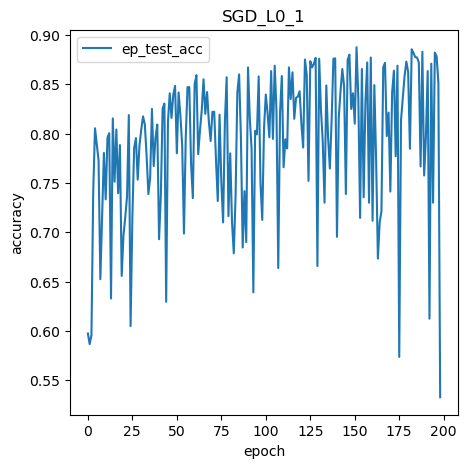

<Figure size 640x480 with 0 Axes>

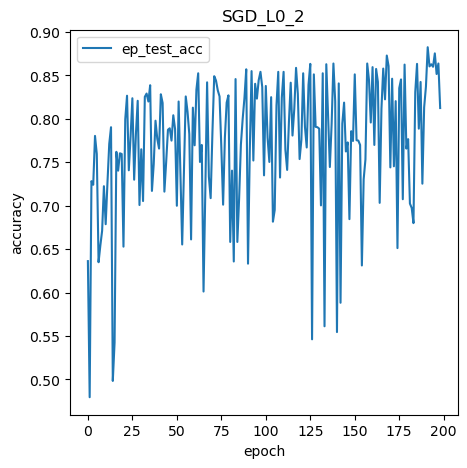

<Figure size 640x480 with 0 Axes>

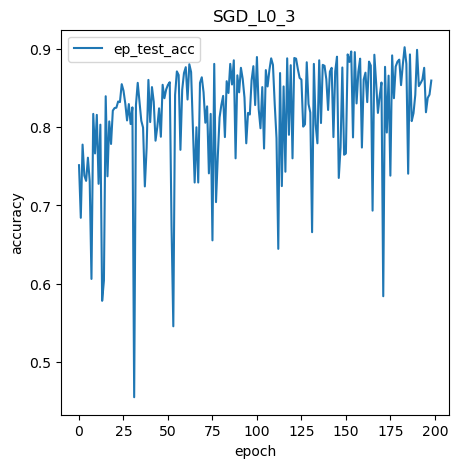

<Figure size 640x480 with 0 Axes>

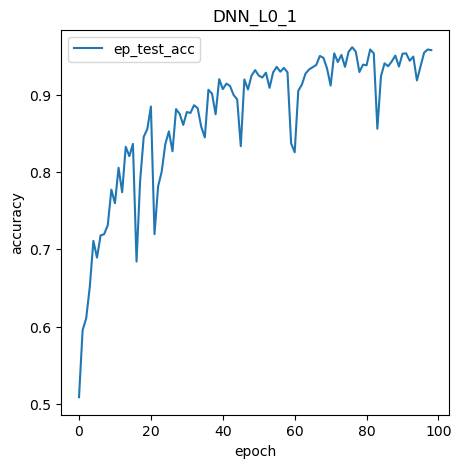

<Figure size 640x480 with 0 Axes>

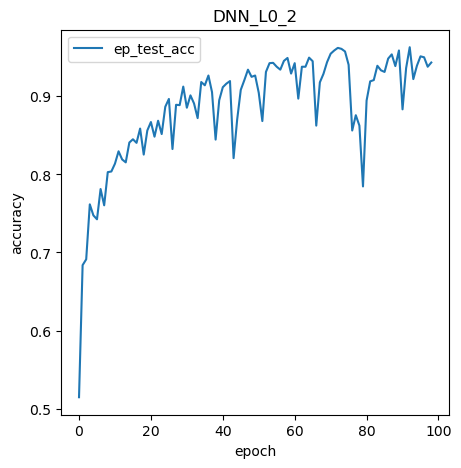

<Figure size 640x480 with 0 Axes>

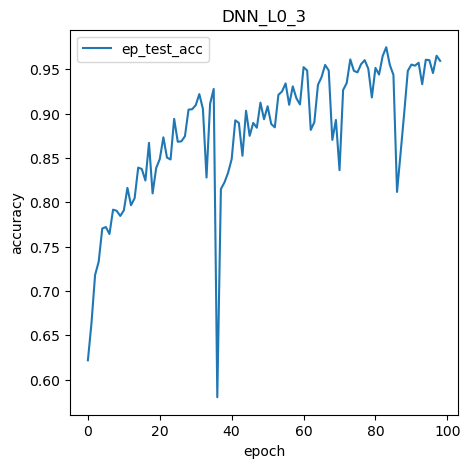

In [59]:
for i in range(len(SGD_models)):
    draw_accuracy(model=SGD_models[i], acc_type="ep_test_acc")
    
for i in range(len(DNN_models)):
    draw_accuracy(model=DNN_models[i], acc_type="ep_test_acc")

In [60]:
print("<", input_path.split("/")[-1], ">")
print()

SVM_train_acc_accuracys =[]
SVM_test_acc_accuracys = []
DNN_train_acc_accuracys =[]
DNN_test_acc_accuracys = []
for i in range(len(higher_layer_info[target_block][target_middle_chapter])):
    level = higher_layer_info[target_block][target_middle_chapter][i]
    
    svm_max_train_acc = max(SGD_models[i].train_acc["ep_train_acc"])
    svm_max_test_acc = max(SGD_models[i].test_acc["ep_test_acc"])
    # print("SVM train", level, "{:.2f}".format(svm_max_train_acc))
    print("SVM test", level, "{:.2f}".format(svm_max_train_acc))
    SVM_train_acc_accuracys.append(max(SGD_models[i].train_acc["ep_train_acc"]))
    SVM_test_acc_accuracys.append(max(SGD_models[i].test_acc["ep_test_acc"]))
    
    dnn_max_train_acc = float(max(DNN_models[i].train_acc["ep_train_acc"]))
    dnn_max_test_acc = float(max(DNN_models[i].test_acc["ep_test_acc"]))
    # print("DNN train", level, "{:.2f}".format(dnn_max_train_acc))
    print("DNN test", level, "{:.2f}".format(dnn_max_train_acc))
    DNN_train_acc_accuracys.append(dnn_max_train_acc)
    DNN_test_acc_accuracys.append(dnn_max_test_acc)
    
# print("SVM train avg", sum(SVM_train_acc_accuracys) / len(SVM_train_acc_accuracys))
# print("DNN train avg", sum(DNN_train_acc_accuracys) / len(DNN_train_acc_accuracys))
print("SVM test avg", "{:.2f}".format(sum(SVM_test_acc_accuracys) / len(SVM_test_acc_accuracys)))
print("DNN test avg", "{:.2f}".format(sum(DNN_test_acc_accuracys) / len(DNN_test_acc_accuracys)))

print("--------------------------------------")

< RJ_중1_2104B100.xlsx >

SVM test L0_1 0.89
DNN test L0_1 0.97
SVM test L0_2 0.87
DNN test L0_2 0.97
SVM test L0_3 0.90
DNN test L0_3 0.97
SVM test avg 0.89
DNN test avg 0.97
--------------------------------------


In [61]:
target_sub_columns_names = ["개념원리정답율", "개념적용정답율", "개념활용정답율"] # 반드시 순서가 쉬움 -> 어려움순이어야함
alias_sub_column_name = ["C1", "C2", "C3"]

result_paths = []
studied_orders = []

sub_study_paths = []
for i in range(len(higher_layer_info[target_block][target_middle_chapter])):
    target_layer = higher_layer_info[target_block][target_middle_chapter][i]
    
    
    result_path, studied_order = grade_path(test_data=SGD_models[i].X_test, 
                                     model_type="DNN", 
                                     target_v = target_layer)
    
    result_paths.append(result_path)
    studied_orders.append(studied_order)
    
    # sub study path
    _, sub_study_path = get_sub_study_path(SGD_models[i], target_sub_columns_names, alias_sub_column_name)
    sub_study_paths.append(sub_study_path)
    

KeyError: 'RJ'

In [62]:
result_paths[0]

IndexError: list index out of range

In [55]:
sub_study_paths[0]

{'L1_1': ['C1', 'C2', 'C3']}